In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import robot_room as robot
from histogram_filters import plot_distribution, convolve, get_room_observation_likelihood, \
        update, run_histogram_filter, get_hist_circular_mean_var, generate_sample, plot_estimations,\
        get_walking_noise_perfect_1, get_walking_noise_example_1, plot_interactive_histogram, plot_histogram_entropy_std
import draw_hmm as hmm
from IPython import display
from IPython.display import YouTubeVideo
from scipy.stats import entropy
%matplotlib inline

In [88]:
matplotlib.__version__, np.__version__, 

('2.1.0', '1.13.3')

# Filtros Bayesianos

Son algoritmos que estiman recursivamente la distribución de probabilidad sobre un estado latente $s$ (por ejemplo: la posición de un robot) condicionada en la historia de las observaciones $o$ (ejemplo: imágenes de una camara, un sensor, etc) y acciones $a$ (Ejemplo: pasos del robot, velocidad, etc)

*Cita original:*  
"It is an algorithm to recursively estimate a probability distribution
over a latent state $s$ (e.g. robot position) conditioned on the history of observations $o$ (e.g. camera
images) and actions $a$ (e.g. steps, velocity, etc)" - (Thrun et al., 2005) 

**Estado Latente $s$**: Variable aleatoria no observable (Se observan otras variables correlacionadas)

La distribución de probabilidad de $S_i$ dadas las acciones $a_i$ y las observaciones $o_i$ se llama creencia ("belief")

$P(S_i|a_1,.. ,a_n, o_1,...,o_m)$

Ejemplo:
Es la probabilidad de que este a 3 metros de la posición inicial dado que el robot realizó 5 pasos en la dirección sur y las 5 mediciones del robot luego de cada paso

Hipotesis: (Esta técnica posee 2 pasos fundamentales: Predicción y Medición)
- Propiedad de Markov de los estados
- Prediction: Basada en el paso anterior
- Medición (Observación): Basada en la medición actual

# Filtros de histogramas
Es un tipo de filtro de Bayes que representa la creencia ("belief") como un histograma. Estima los estados de un sistema.

**Características principales:**
- No paramétrico: Histograma completo (vs paramétrico: Distribución Gaussiana con vector de medias y matriz de covarianza definidas)
- Multi-modal

**Aplicaciones:**
- Uno de los filtros utilizados por Google para hallar la posición del self-driven car

# Ejemplo del Robot. Donde estoy?

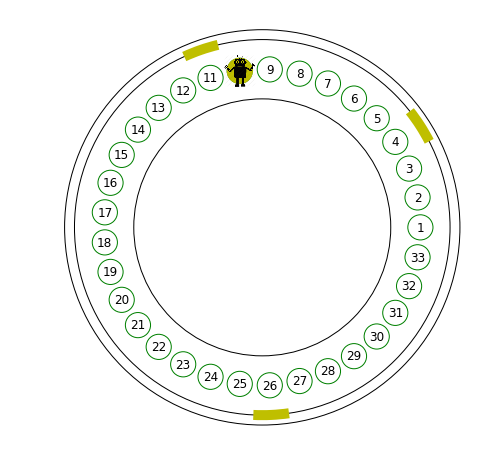

In [89]:
doors = np.array([4, 11, 26])
N = 33
robot.plot_robot_room(loc = 10, N=N, doors = doors, figsize = (8,8))

** Descripción del diagrama**
- El robot esta en un pasillo circular con 33 posibles posiciones: Estados $s_i$
- Hay 3 puertas marcadas en este diagrama
- El robot quiere estimar su posición sensando si hay o no una puerte delante suyo: Etapa de medición para obtener observaciones $o_i$

** Las Hipotesis**
- La observación es ruidosa: Puede sensar una puerta cuando en realidad no la hay aunque con baja probabilidad y viceversa
- Las acciones $a_i$ del robot no son perfectas: Cuando el robot da un paso, podria estar avanzando mas de uno

## Las hipotesis expresadas en forma matematica
### Etapa de observación/medición - El likelihood 
$X$ es la V.A. que el robot observa y $P(X=door|S_k)$ es su distribución dado que el robot esta en la posición $S_k$

$\large \mathcal{L}(S_k) = P(X=door|S_k)$ es el **likelihood**

- El likelihood es dato
- La suma del likelihood sobre todos los $S_k$ puede ser mayor que uno
- $P(X=door|S_k) + P(X=wall|S_k) = 1$

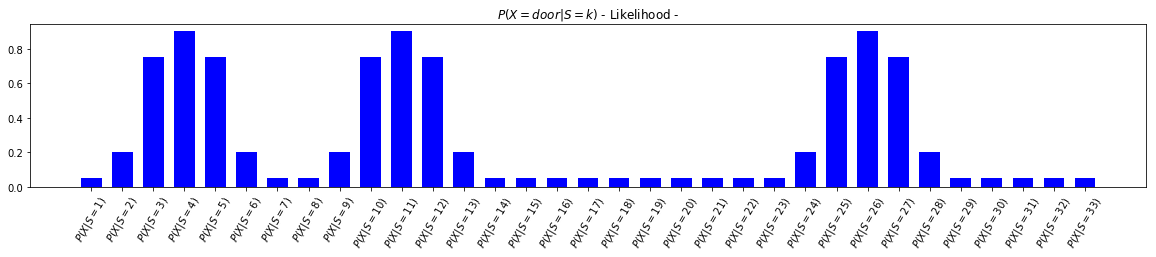

In [90]:
pulse = np.array([0.2, 0.75, 0.9, 0.75, 0.2])
noise = 0.05
str_indexes_likelihood =  ['$P(X|S=%s)$'%int(i+1) for i in range(N)]
likelihood = get_room_observation_likelihood(N = N, doors = doors, pulse = pulse, noise = noise)
plot_distribution(likelihood['door'], title = '$P(X=door|S=k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)

https://www.youtube.com/watch?v=sm60vapz2jQ

### Etapa de predicción - Acción del Robot - Las Probabilidades de Transición

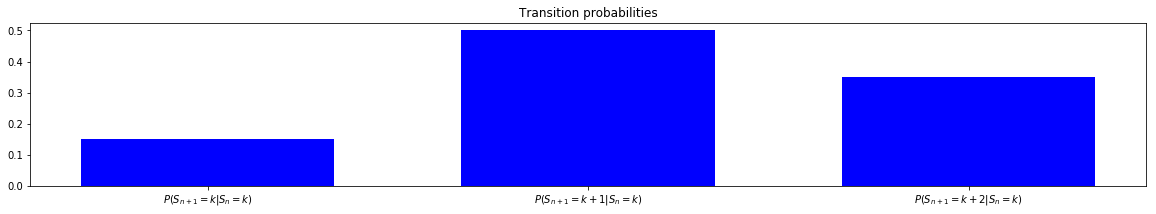

In [91]:
W = np.zeros(3)
W[0] = 0.15
W[1] = 0.50
W[2] = 0.35
str_indexes_transition =  ['$P(S_{n+1}=k|S_n=k)$', 
                           '$P(S_{n+1}=k+1|S_n=k)$', 
                           '$P(S_{n+1}=k+2|S_n=k)$']
plot_distribution(W, title = 'Transition probabilities', str_indexes= str_indexes_transition, rotation = 0)

- Las probabilidades de transición son tambien dato

## El modelo
- Los histogramas son discretos
- $S_k \quad k=1,...,33$ son todas las posibles posiciones del robot: **Estados latentes**
- $S_k$ No es observable, Es un estado latente. Observamos $X_k$ que esta correlacionada con $S_k$

### HMM (Hidden Markov Model)

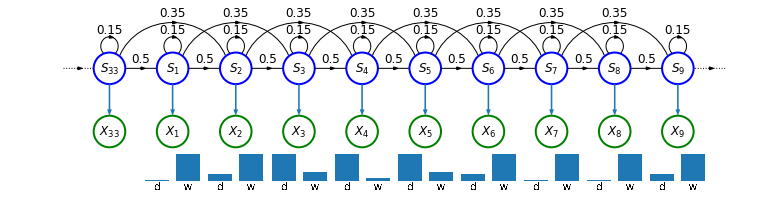

In [92]:
images_map_perfect = hmm.get_image_map_sensor(likelihood['door'])
hmm.plot_basic_hmm_model(N = N, 
                         N_states_visible = 10, 
                         circular = True, 
                         stay_step_prob = W[0], 
                         one_step_prob = W[1], two_step_prob = W[2], images_map = images_map_perfect)

En el diagrama de arriba podemos ver lo siguiente:
- $X_k$: La variable obseervada con su likelihood
- $S_k$: Las variables de estado (latente) con su probabilidad de transición

### Modelo generativo

** Como elijo probabilidades de transición?**

Es un array que en 0 tiene la probabilidad de quedarse en el estado, en 1 de avanzar una posición y asi ....

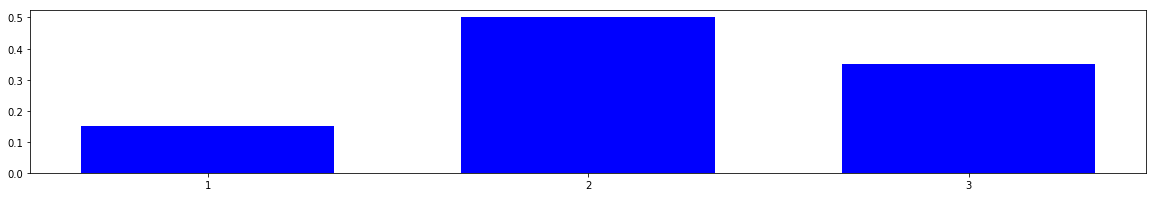

In [93]:
# Original
W1 = np.zeros(3); W1[0] = 0.15; W1[1] = 0.50; W1[2] = 0.35
# Walk with steps of 3 with p=1
W2 = np.zeros(4); W2[3] = 1; 
# Walk with steps of 11 with p=1
W3 = np.zeros(12); W3[11] = 1; 
# Dont walk
W4 = np.zeros(1); W4[0] = 1; 
W_gen = W1
plot_distribution(W_gen)

** Como defino el likelihood?**

Hacemos la convolución entre la posición de las puertas y el pulso

In [94]:
pulse1 = np.array([0.2, 0.75, 0.9, 0.75, 0.2])
#pulse2 = np.array([0, 0, 0.9, 0, 0])
noise = 0.05


likelihood_gen = get_room_observation_likelihood(N = N, doors = doors, pulse = pulse1, noise = noise)
likelihood_gen

{'door': array([ 0.05,  0.2 ,  0.75,  0.9 ,  0.75,  0.2 ,  0.05,  0.05,  0.2 ,
         0.75,  0.9 ,  0.75,  0.2 ,  0.05,  0.05,  0.05,  0.05,  0.05,
         0.05,  0.05,  0.05,  0.05,  0.05,  0.2 ,  0.75,  0.9 ,  0.75,
         0.2 ,  0.05,  0.05,  0.05,  0.05,  0.05]),
 'wall': array([ 0.95,  0.8 ,  0.25,  0.1 ,  0.25,  0.8 ,  0.95,  0.95,  0.8 ,
         0.25,  0.1 ,  0.25,  0.8 ,  0.95,  0.95,  0.95,  0.95,  0.95,
         0.95,  0.95,  0.95,  0.95,  0.95,  0.8 ,  0.25,  0.1 ,  0.25,
         0.8 ,  0.95,  0.95,  0.95,  0.95,  0.95])}

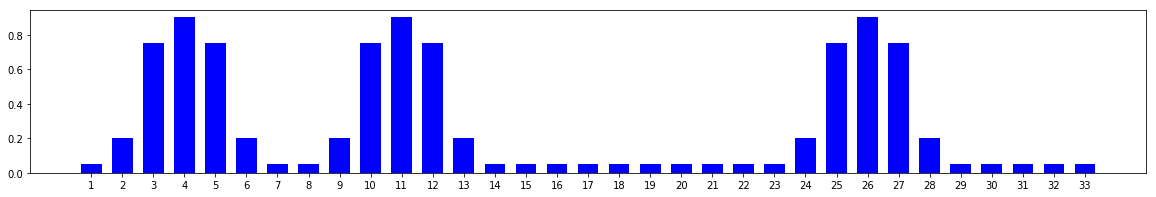

In [95]:
plot_distribution(likelihood_gen['door'])

[('door', 9), ('door', 11), ('wall', 13), ('door', 15), ('wall', 16), ('wall', 16), ('wall', 18), ('wall', 19), ('wall', 19), ('wall', 20)]
Probabilidades de transición teóricas vs simuladas:
Teóricas: [ 0.15  0.5   0.35]
Simuladas: [0.15272727272727274, 0.5018181818181818, 0.34545454545454546]


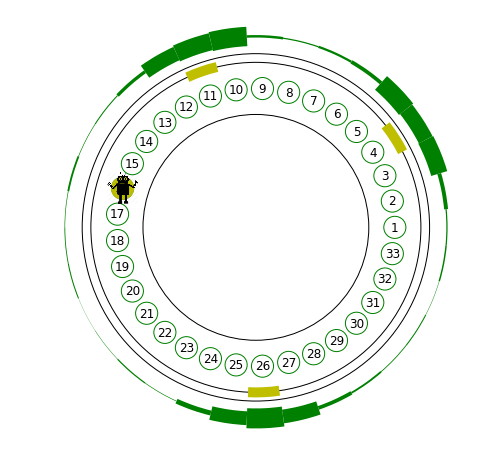

In [96]:
# Numero de pasos
steps = 100*N # Cambiar la cantidad de pasos y ver como se modifica
# Dados el likelihood, Las probabilidades de transición y el estado inicial
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood_gen, W_gen, 
                                                               initial_state = 10,
                                                               steps = steps)
print([ (m,loc[i]) for i,m in enumerate(measurements)][:10])
print('Probabilidades de transición teóricas vs simuladas:')
print('Teóricas:',W)
print('Simuladas:',steps_stats)
robot.plot_robot_room(loc = loc[-1], N=N, doors = doors, sample_stats = sample_stats)

Correrlo con:
- Condiciones iniciales diferentes
- Diferentes pasos
- Diferentes probabilidades de transión
- Difirente Likelihood

Si mantengo los parametros igual y corro varias veces la simulación, termina el robot siempre en la misma posición? Porque?

### Cual es la información que conozco?

**Observación (Caracteristicas del sensor)**

$X$ y $S$ estan correlacionadas

$P(X = $ "door" | $S =$ "infront door" $)$ = 0.9 $\quad P(X = $ "wall" | $S =$ "infront door" $)$ = 0.1

$P(X = $ "door" | $S =$ "1 away from door" $)$  = 0.75 $\quad P(X = $ "wall" | $S =$ "1 away from door" $)$  = 0.25

$P(X = $ "door" | $S =$ "2 away from door" $)$  = 0.2  $\quad P(X = $ "wall" | $S =$ "2 away from door" $)$ = 0.8

$P(X = $ "door" | $S =$ "other" $)$ = 0.05 $\quad P(X = $ "wall" | $S =$ "other" $)$ = 0.95


** Predicción (Que tan presiso es el robot en sus movimientos)**

$S_{n+1} = S_{n} + W$  (Suma de V.A.)

$P(W=0) = 0.15$

$P(W=1) = 0.50$

$P(W=2) = 0.35$


# Donde esta el Robot?
Vamos a seguir los siguientes pasos:
1. Obtener el histograma a priorí (Suponemos usualmente máxima confusión) 
2. Observo para luego estimar el histograma a posteriori
3. Predecir el nuevo histograma luego de que el robot ejecuta la acción
4. Ir al paso 2

## Máxima Confusión - Histograma a Priori

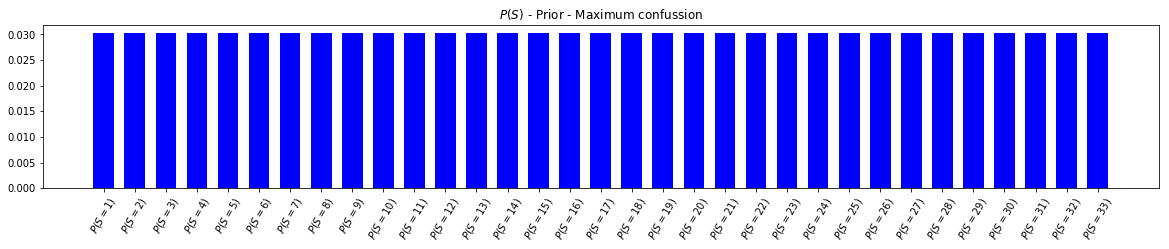

In [97]:
prior = np.ones(N)/N
str_indexes_prior =  ['$P(S=%s)$'%int(i+1) for i in range(N)]
plot_distribution(prior, title = '$P(S)$ - Prior - Maximum confussion', str_indexes= str_indexes_prior, 
                         rotation = 60)

No sabemos donde estamos por lo que todas las posiciones son equiprobables

### Entropía

La entropía normalizada es una buena medida de la incerteza en distribuciones multimodales.

¿Por que el desvío estandar no sería tan buena medidad?

In [98]:
print("Entropía Normalizada:",entropy(prior, base = 2)/np.log2(N))

Entropía Normalizada: 1.0


Entropía Normalizada: 0.0


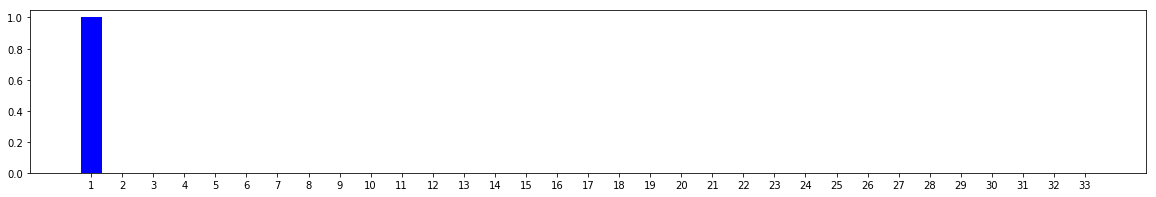

In [99]:
delta = np.zeros(N)
delta[0] = 1
plot_distribution(delta)
print("Entropía Normalizada:",entropy(delta, base = 2)/np.log2(N))

Entropía Normalizada: 0.143114926749


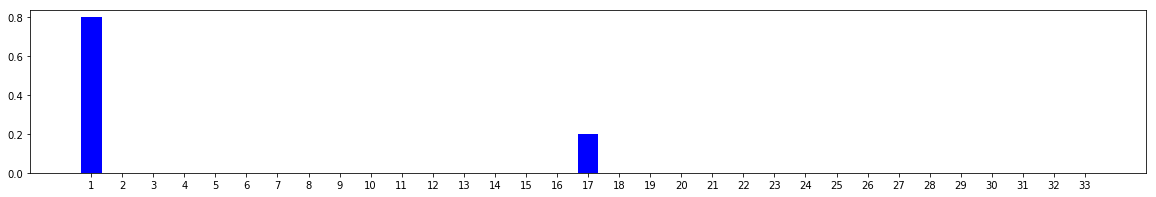

In [100]:
delta2 = np.zeros(N)
delta2[0] = 0.8
delta2[int((N-1)/2)] = 0.2
plot_distribution(delta2)
print("Entropía Normalizada:",entropy(delta2, base = 2)/np.log2(N))

## Etapa de observación (Medición) y Teorema de Bayes. AKA Update

### Supongamos que observamos una puerta

El likelihood es $P(X=door|S=k)$:

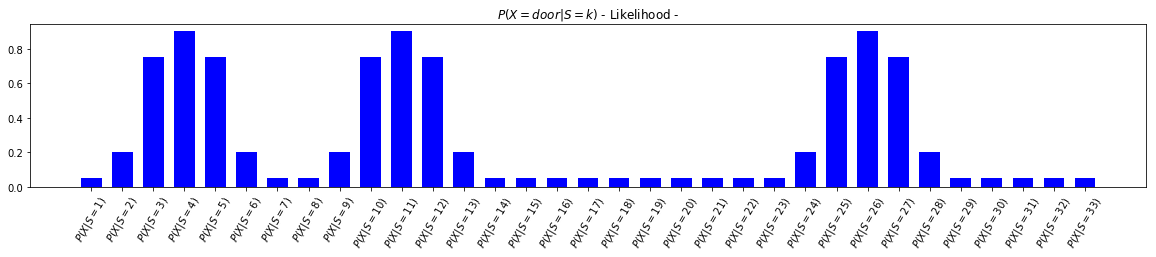

In [101]:
plot_distribution(likelihood['door'], title = '$P(X=door|S=k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)

Pero queremos la a posteriori: $P(S=k|X)$

**Teorema de Bayes**

\begin{equation} 
\large P(S=k\ | \ X) = \frac{P(X\ |\ S=k) \ P(S=K)}{P(X)} \\
\end{equation}

$P(X) = \sum_i{P(X,S_i)} = \sum_i{P(X|S_i)P(S_i)}$

En la mayoría de los casos calcular P(x). Es equivalente a simplemente normalizar

$P(S=k|X) = \alpha{P(X|S=k)P(S=k)}$

** Entonces multiplicamos la a priori por el likelihood para obtener lo deseado **

Suma de todos los bins - P(X):  0.281818181818


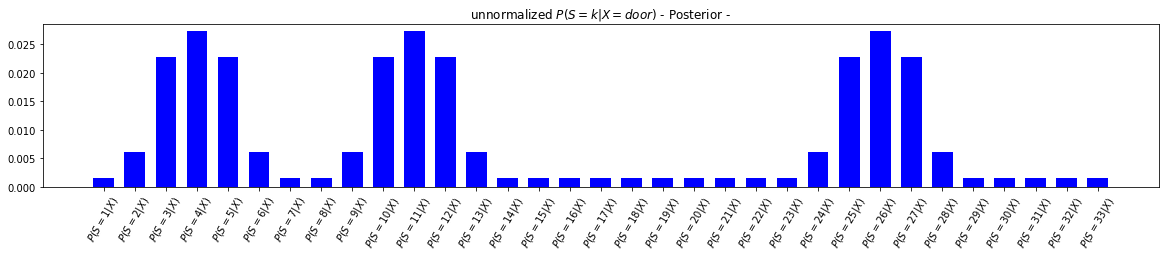

In [102]:
posterior_unnorm = likelihood['door']*prior

str_indexes_posterior =  ['$P(S=%s|X)$'%int(i+1) for i in range(len(prior))]
plot_distribution(posterior_unnorm, title = 'unnormalized $P(S=k|X=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
sum_over_all = posterior_unnorm.sum()
print('Suma de todos los bins - P(X): ',sum_over_all)

** Normalizamos **

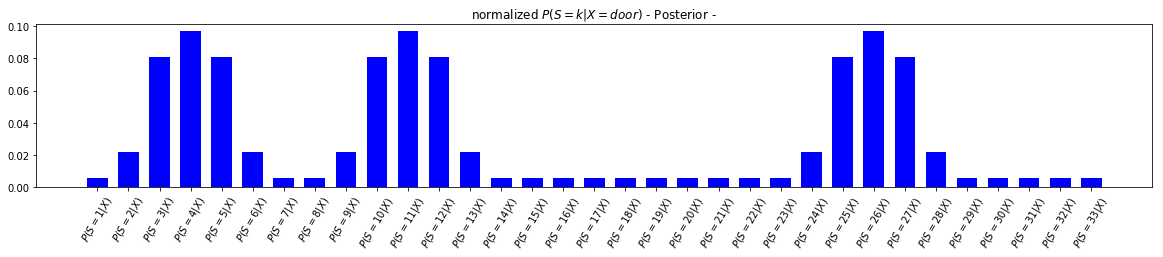

In [103]:
posterior = posterior_unnorm/sum_over_all
plot_distribution(posterior, title = 'normalized $P(S=k|X=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

### Que pasaba si en realidad observaramos una pared?

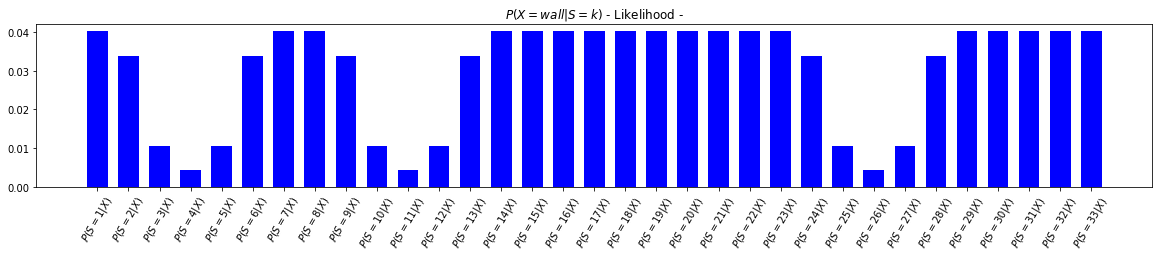

In [104]:
posterior_unnorm_wall = likelihood['wall']*prior
posterior_norm_wall = posterior_unnorm_wall/posterior_unnorm_wall.sum()
plot_distribution(posterior_norm_wall, title = '$P(X=wall|S=k)$ - Likelihood -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

** Tanto la entropía dado una pared como dado una puerta bajan, por que baja mas dado una pared? **

In [105]:
print("normalized entropy of posterior given door:",entropy(posterior, base = 2)/np.log2(N))
print("normalized entropy of posterior given wall:",entropy(posterior_norm_wall, base = 2)/np.log2(N))

normalized entropy of posterior given door: 0.828650552514
normalized entropy of posterior given wall: 0.962264345679


## Etapa de predicción y suma de V.A.(Convolution)

Supongamos entonces que observamos una puerta:

$\huge S_{n+1} = S_{n} + W$

Tenemos la a posteriori $P(S_n=k|X_n = door)$ y queremos predecir $P(S_{n+1}=k|X_n = door)$

** A Posteriori **

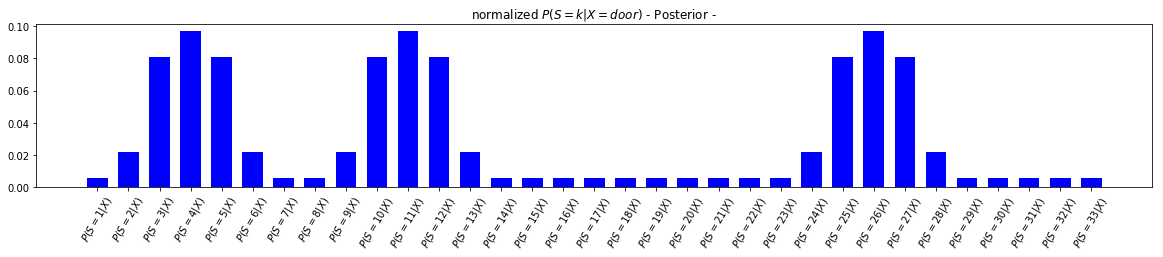

In [106]:
plot_distribution(posterior, title = 'normalized $P(S=k|X=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

**Y las probabilidades de transición:**

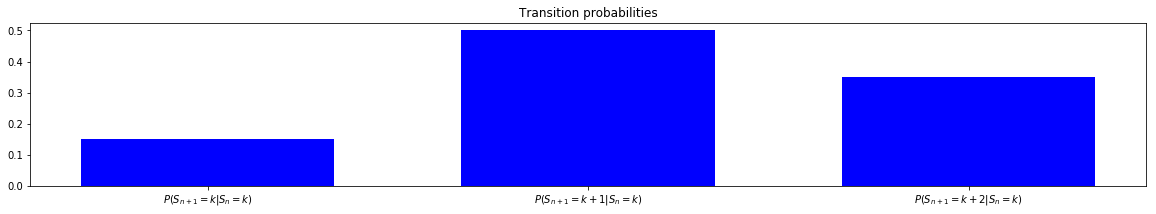

In [107]:
transition = W
plot_distribution(transition, title = 'Transition probabilities', str_indexes= str_indexes_transition, rotation = 0)

La distribución de la suma de V.A. independientes se calcula como la convolución de las distribuciones de cada V.A

Haciendo la convolución obtenemos:

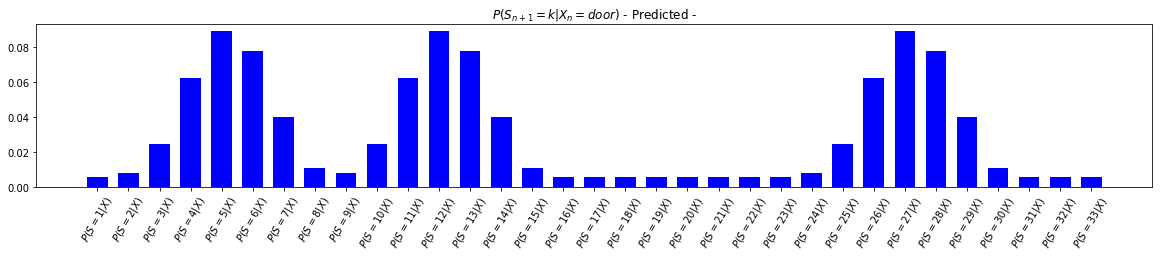

In [108]:
predicted = convolve(posterior, transition)
plot_distribution(predicted, title = '$P(S_{n+1}=k|X_n = door)$ - Predicted -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

**Notar:**
- El pico se movio en una posición hacia la derecha
- El estado a la derecha del pico es mas alto que el de la izquierda. A que se debe?

** Que pasa con la entropía? **

In [109]:
print("normalized entropy of posterior:",entropy(posterior, base = 2)/np.log2(N))
print("normalized entropy of predicted:",entropy(predicted, base = 2)/np.log2(N))

normalized entropy of posterior: 0.828650552514
normalized entropy of predicted: 0.862888454862


## Observemos nuevamente. Supongamos una puerta nuevamente

Entropía normalizada de posterior_2: 0.704906880601


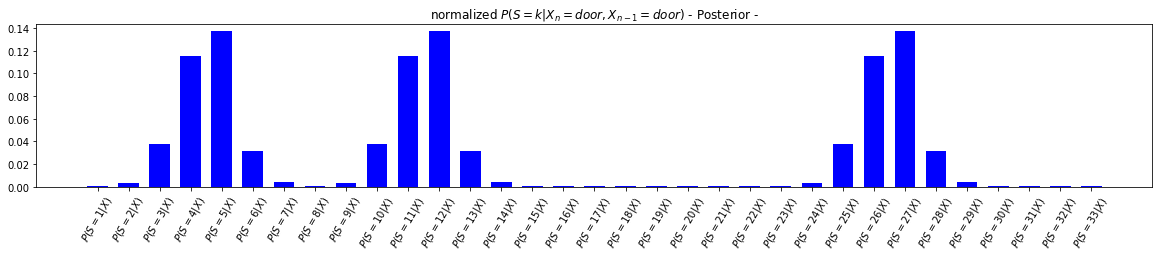

In [110]:
posterior_unnorm_2 = likelihood['door']*predicted
posterior_2 = posterior_unnorm_2/posterior_unnorm_2.sum()

plot_distribution(posterior_2, title = 'normalized $P(S=k|X_n=door, X_{n-1}=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
print("Entropía normalizada de posterior_2:",entropy(posterior_2, base = 2)/np.log2(N))

## Hacemos una nueva predicción

Entropía normalizada de predicted_2: 0.76695718456


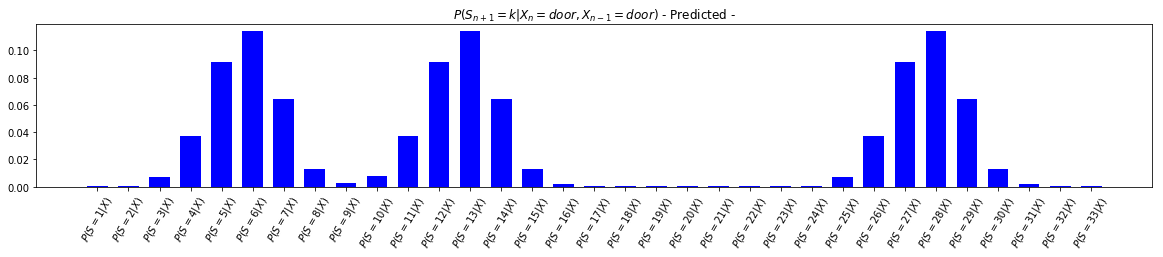

In [111]:
predicted_2 = convolve(posterior_2, transition)
plot_distribution(predicted_2, title = '$P(S_{n+1}=k|X_n=door, X_{n-1}=door)$ - Predicted -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
print("Entropía normalizada de predicted_2:",entropy(predicted_2, base = 2)/np.log2(N))

## Una observación más: Pero vemos una pared {door, door, wall}

Entropía normalizada de posterior_3: 0.709467683369


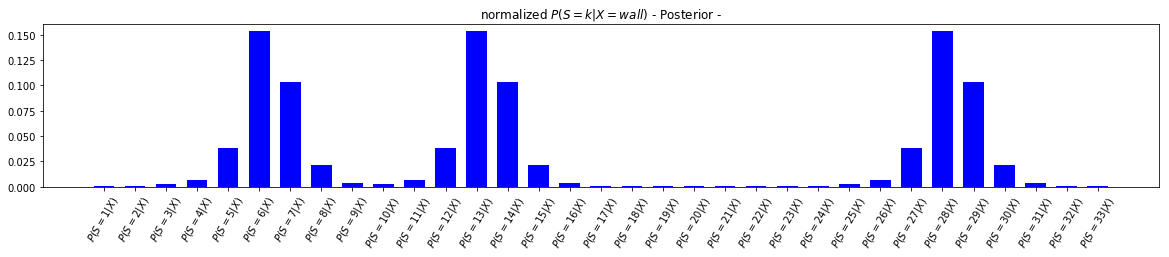

In [116]:
posterior_unnorm_3 = likelihood['wall']*predicted_2
posterior_3 = posterior_unnorm_3/posterior_unnorm_3.sum()

plot_distribution(posterior_3, title = 'normalized $P(S=k|X=wall)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
print("Entropía normalizada de posterior_3:",entropy(posterior_3, base = 2)/np.log2(N))

Esto se podría pensar como que arranque en 4 y luego despues de 2 predicciones quede en 6. (O lo mismo para 11 y 26)

## Que obtendría si observo 3 puertas?: {door, door, door}

Entropía normalizada de posterior_3_bis: 0.675024065111


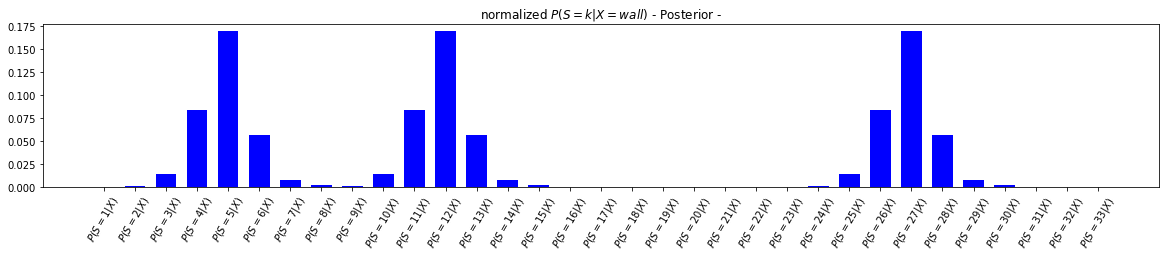

In [117]:
posterior_unnorm_3_bis = likelihood['door']*predicted_2
posterior_3_bis = posterior_unnorm_3_bis/posterior_unnorm_3_bis.sum()

plot_distribution(posterior_3_bis, title = 'normalized $P(S=k|X=wall)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
print("Entropía normalizada de posterior_3_bis:",entropy(posterior_3_bis, base = 2)/np.log2(N))

Lo mas probable es que este en 5 por que empecé en 3 e hice dos predicciones (pasos). Lo mismo para el 10 y 25

# Filtros de histogramas: El algoritmo completo

## Update (Observación):

In [128]:
def update(p, X, likelihood):
    # p: probabilidad a priori
    # X: Medición. [puede ser door o wall en este ejemplo]
    # likelihood: Diccionario donde likelihood[X] es el likelihood de X dado cada uno de los posibles estados
    # posteriori sin normalizar
    posterior = likelihood[X]*p
    # Normalize it
    normalized = posterior/posterior.sum()
    return normalized

## Predicción (Acción)

In [127]:
def prediction(posterior, transition):
    # posterior: posterior probability distribution
    # transition: transition probability distribution
    return convolve(posterior, transition)

## The filter

In [129]:
def histogram_filter(W, measurements, likelihood, prior = np.ones(N)/N):
    # W: Distribución de las probabilidades de transición
    # measurements: Lista de observaciones. The i'th observation Xi = measurements[i]
    # likelihood: Diccionario donde likelihood[X] es el likelihood de X dado cada uno de los posibles estados
    # prior: Distribución inicial, Máxima confusion 
    normalized_entropy = []
    mean_array = []
    var_array = []
    for i in range(len(measurements)):
        posterior = update(prior, measurements[i], likelihood)
        normalized_entropy.append(entropy(posterior, base = 2)/np.log2(len(prior)))
        mean, variance = get_hist_circular_mean_var(posterior)
        mean_array.append(mean)
        var_array.append(variance)
        predicted = prediction(posterior, W)
        prior = predicted
    return posterior, predicted, normalized_entropy, mean_array, var_array

In [125]:
print(W)
print(measurements[:10])
print(likelihood['door'])
print(likelihood['wall'])

[ 0.15  0.5   0.35]
['door', 'door', 'wall', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall']
[ 0.05  0.2   0.75  0.9   0.75  0.2   0.05  0.05  0.2   0.75  0.9   0.75
  0.2   0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.2
  0.75  0.9   0.75  0.2   0.05  0.05  0.05  0.05  0.05]
[ 0.95  0.8   0.25  0.1   0.25  0.8   0.95  0.95  0.8   0.25  0.1   0.25
  0.8   0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.95  0.8
  0.25  0.1   0.25  0.8   0.95  0.95  0.95  0.95  0.95]


In [141]:
def plot_histogram_entropy_std_example(measurements, transition, likelihood, prior, n_steps = 1):
    # Debemos usar la del paquete, esta es solo propositos demostrativos
    N = len(prior)
    posterior, predicted, normalized_entropy, mean_array, var_array = histogram_filter(transition, 
                                                                measurements[:n_steps], 
                                                                likelihood, 
                                                                prior = np.ones(N)/N)
    #print(measurements[:n_steps])
    f = plt.figure(figsize=(20,10))
    plt.subplot(2, 1, 1)
    plot_distribution(posterior, title = 'normalized $P(S=k|X)$ - Posterior -', fig = f)
    plt.subplot(2, 2, 3)
    plt.title("Normalized entropy")
    plt.plot(normalized_entropy)
    plt.subplot(2, 2, 4)
    plt.title("Standard deviation")
    plt.plot(np.array(var_array)**(0.5))
    plt.show()
    print("Entropía normalizada de ultima a posteriori:",normalized_entropy[-1])

### Ejemplo 1. 
** Comenzando en la posición 1 y obteniendo la muestra de cada X de mayor probabilidad (13 iteraciones)**

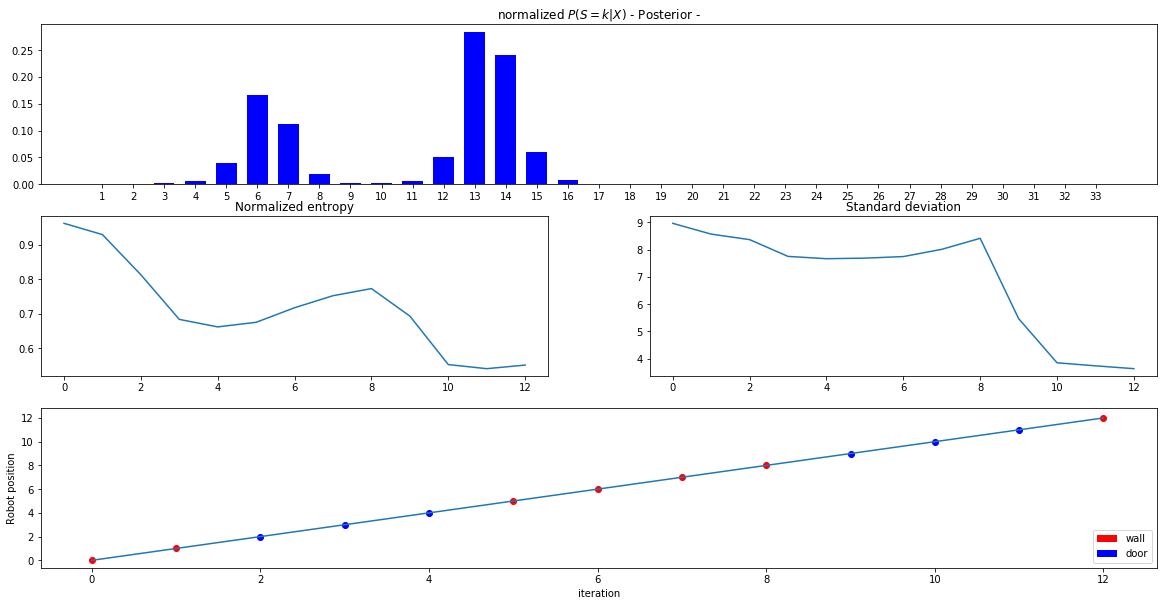

normalized entropy of last posterior: 0.551677713508


In [142]:
short_walk = ['wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 'door', 'wall']

plot_histogram_entropy_std(short_walk, transition, likelihood, prior, n_steps = len(short_walk), real_positions=range(len(short_walk)))

### Ejemplo 2. Ciclo completo. 
** Comenzando en la posición 1 y obteniendo la muestra de cada X de mayor probabilidad (Ciclo completo de iteraciones)**

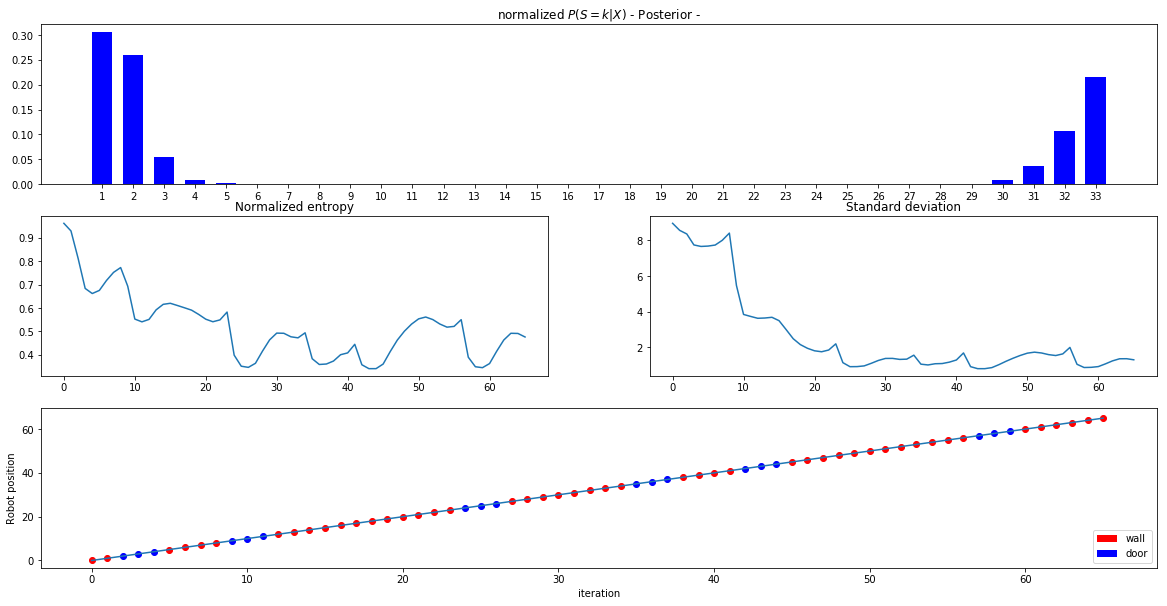

normalized entropy of last posterior: 0.47653104276


In [136]:
cicle = ['wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall',
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall']

plot_histogram_entropy_std(cicle, transition, likelihood, 
                           prior, n_steps=len(cicle), real_positions=range(len(cicle)))

### Ejemplo 3. (N ciclos completos)

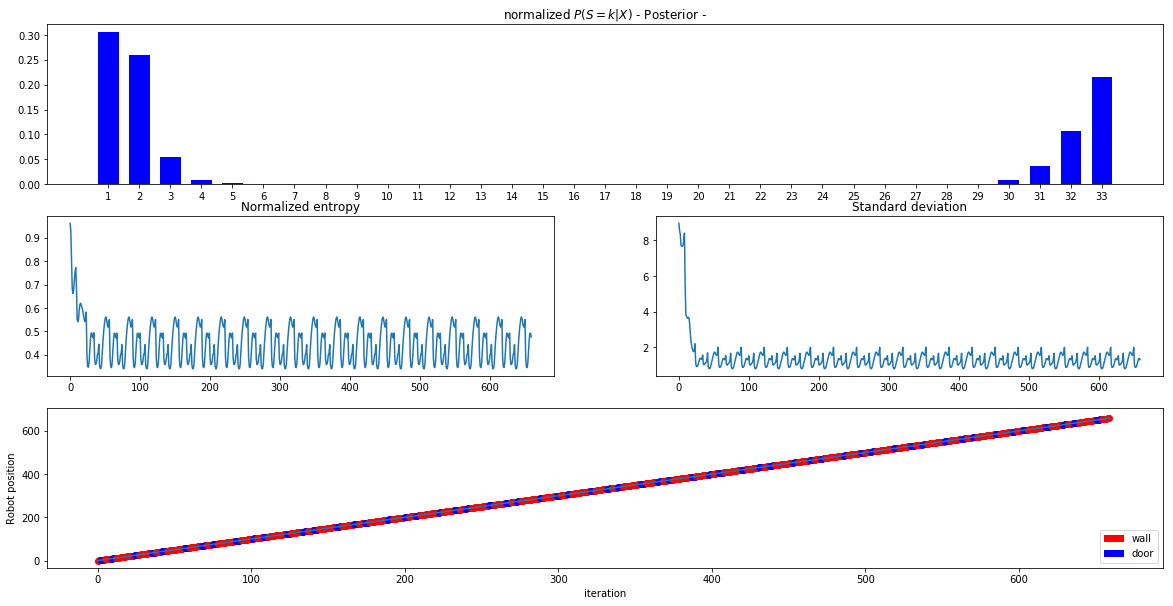

normalized entropy of last posterior: 0.476530977539


In [137]:
cicle = ['wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall',
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall']
n_of_cicles = 10
n_cicles = []
for i in range(n_of_cicles):
    n_cicles = n_cicles + cicle

plot_histogram_entropy_std(n_cicles, transition, likelihood, prior, 
                           n_steps = len(n_cicles), real_positions=range(len(n_cicles)))

A que se debe la oscilación remanente?

El error mientras el robot camina. Las probabilidades de transición

# Modelo generativo

Generemos con este modelo algo mas "real"

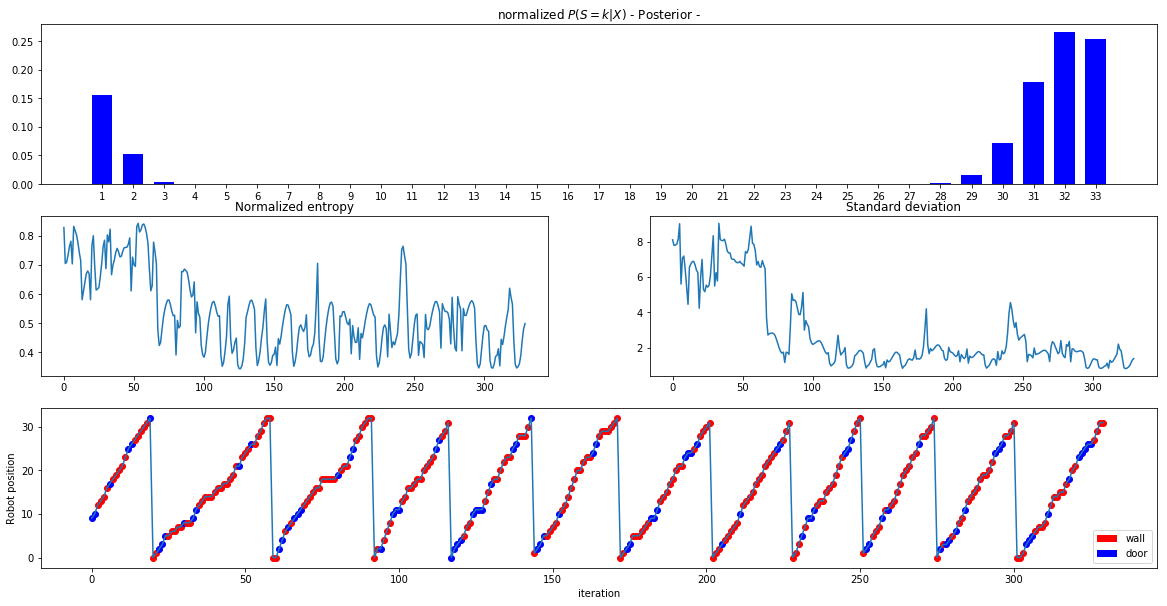

normalized entropy of last posterior: 0.498585196227


In [156]:
steps = 10*N
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood_gen, transition, 
                                                               initial_state = 10,
                                                               steps = steps)
#plot_interactive_histogram(measurements, transition, likelihood, prior, steps, real_locations=loc)
plot_histogram_entropy_std(measurements, transition, likelihood, prior, n_steps = len(measurements), real_positions=loc)

## Sin error cuando camina. Caminata perfecta

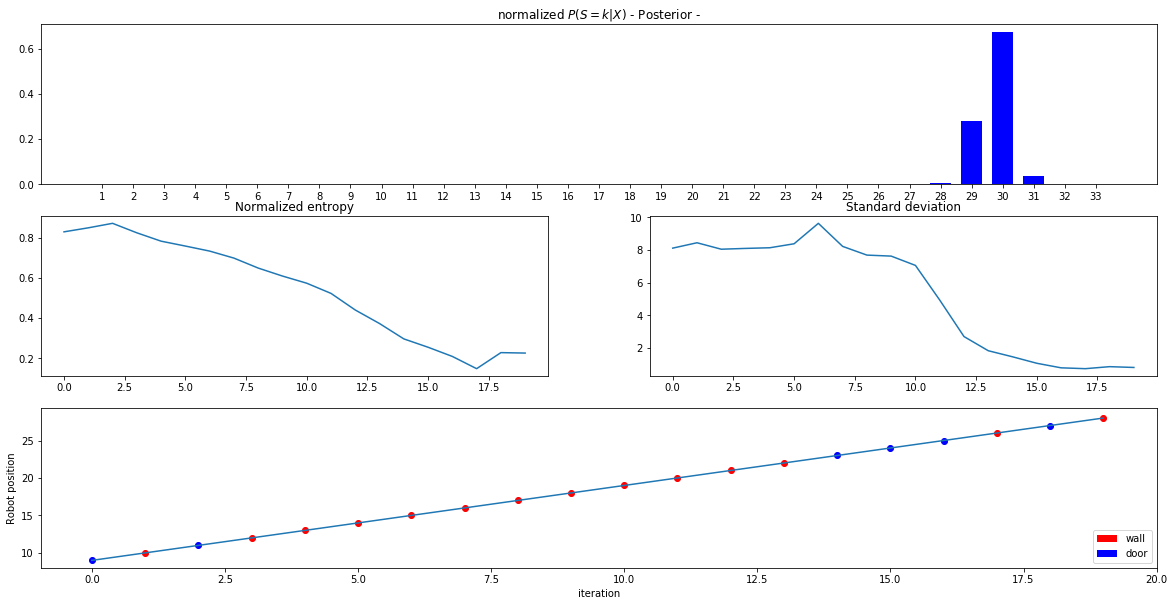

normalized entropy of last posterior: 0.225044210976


In [173]:
steps = 20
transition_1 = np.array([0,1])
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood_gen, transition_1, 
                                                               initial_state = 10,
                                                               steps = steps)
plot_histogram_entropy_std(measurements, transition_1, likelihood, prior, steps, real_positions=loc)
#plot_interactive_histogram(measurements, transition_1, likelihood, prior, steps, real_locations=loc)

Por que la probabilidad es maxima en 9 cuando termina? Recordar que estamos graficando la probabilidad luego de la observación

Verificar el estado inicial para responder la pregunta

## Que pasa si tenemos un sensor perfecto pero no una caminata perfecta?

Cual será el error de observación?

Como será el histograma predicho?

# Referencias

S. Thrun, W. Burgard, and D. Fox. Probabilistic Robotics. MIT Press, Cambridge, MA, 2005.
(https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf)